# Per-Class Analysis with Error Bars

This notebook runs class discrimination tests multiple times to get per-class performance with confidence intervals.

In [ ]:
import os
import sys
import random
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Path setup
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir))
DISCOVER_ROOT = os.path.join(REPO_ROOT, 'discover-hidden-visual-concepts')
sys.path.insert(0, DISCOVER_ROOT)
sys.path.insert(0, REPO_ROOT)

# Import from discover-hidden-visual-concepts repo
sys.path.append(os.path.join(DISCOVER_ROOT, 'src'))
from utils.model_loader import load_model
from models.feature_extractor import FeatureExtractor

# SyntheticKonkle paths - Using 224x224 resized images for faster processing
DATA_DIR = os.path.join(REPO_ROOT, 'data', 'SyntheticKonkle_224')
RESULTS_DIR = os.path.join(REPO_ROOT, 'PatrickProject', 'Chart_Generation')
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
# Dataset setup (same as before)
def build_synthetic_dataset():
    """Combine all labels.csv files from class_color folders."""
    all_data = []
    # Note: In SyntheticKonkle_224, folders are nested under SyntheticKonkle/
    base_dir = os.path.join(DATA_DIR, 'SyntheticKonkle')
    
    class_folders = [d for d in os.listdir(base_dir) 
                    if os.path.isdir(os.path.join(base_dir, d)) 
                    and d.endswith('_color')]
    
    for folder in class_folders:
        labels_path = os.path.join(base_dir, folder, 'labels.csv')
        if os.path.exists(labels_path):
            df = pd.read_csv(labels_path)
            df['folder'] = folder
            all_data.append(df)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df = combined_df.dropna(subset=['class'])
    print(f"Loaded {len(combined_df)} images from {len(class_folders)} classes")
    unique_classes = combined_df['class'].unique()
    print(f"Classes found: {len(unique_classes)}")
    return combined_df

class SyntheticImageDataset(Dataset):
    def __init__(self, df, data_dir, transform):
        self.df = df
        # For SyntheticKonkle_224, images are in nested structure
        self.data_dir = os.path.join(data_dir, 'SyntheticKonkle')
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, row['folder'], row['filename'])
        try:
            img = Image.open(img_path).convert('RGB')
            return self.transform(img), row['class'], row['color'], row['size'], row['texture'], idx
        except:
            img = Image.new('RGB', (224, 224), color='black')
            return self.transform(img), row['class'], row['color'], row['size'], row['texture'], idx

def collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch])
    classes = [b[1] for b in batch]
    colors = [b[2] for b in batch]
    sizes = [b[3] for b in batch]
    textures = [b[4] for b in batch]
    idxs = [b[5] for b in batch]
    return imgs, classes, colors, sizes, textures, idxs

In [ ]:
def run_class_test_per_class(model_name, seed=0, device='cuda' if torch.cuda.is_available() else 'cpu', 
                             batch_size=64, trials_per_class=250):
    """Run class test and return per-class results."""
    
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Load model & transform
    model, transform = load_model(model_name, seed=seed, device=device)
    extractor = FeatureExtractor(model_name, model, device)
    
    # Build dataset and extract embeddings
    df = build_synthetic_dataset()
    ds = SyntheticImageDataset(df, DATA_DIR, transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

    all_embs, all_classes, all_colors, all_sizes, all_textures, all_idxs = [], [], [], [], [], []
    with torch.no_grad():
        for imgs, classes, colors, sizes, textures, idxs in loader:
            feats = extractor.get_img_feature(imgs.to(device))
            feats = extractor.norm_features(feats).cpu().float()
            all_embs.append(feats)
            all_classes.extend(classes)
            all_colors.extend(colors)
            all_sizes.extend(sizes)
            all_textures.extend(textures)
            all_idxs.extend(idxs)
    all_embs = torch.cat(all_embs, dim=0)

    # Group by class and attributes
    class_attr_idxs = defaultdict(lambda: defaultdict(list))
    for idx, cls, col, size, texture in zip(all_idxs, all_classes, all_colors, all_sizes, all_textures):
        class_attr_idxs[cls][(col, size, texture)].append(idx)

    # Track per-class performance
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    # Get unique classes
    unique_classes = list(class_attr_idxs.keys())
    
    # Run trials for each class
    for target_class in tqdm(unique_classes, desc=f"Testing {model_name}"):
        trials_done = 0
        
        # Get all attribute combinations for this class
        for (color, size, texture), idx_list in class_attr_idxs[target_class].items():
            if trials_done >= trials_per_class:
                break
                
            # Find distractors from other classes with same attributes
            other_idxs = []
            for other_cls in unique_classes:
                if other_cls != target_class:
                    if (color, size, texture) in class_attr_idxs[other_cls]:
                        other_idxs.extend(class_attr_idxs[other_cls][(color, size, texture)])
            
            if len(idx_list) >= 1 and len(other_idxs) >= 3:
                # Run multiple trials for this combination
                n_trials = min(10, trials_per_class - trials_done)
                
                for _ in range(n_trials):
                    # Pick query
                    q = random.choice(idx_list)
                    
                    # Build prototype
                    same_group = [i for i in idx_list if i != q]
                    if same_group:
                        proto = all_embs[[all_idxs.index(i) for i in same_group]].mean(0)
                    else:
                        proto = all_embs[all_idxs.index(q)]
                    proto = proto / proto.norm()

                    # Pick distractors
                    distractors = random.sample(other_idxs, min(3, len(other_idxs)))
                    candidates = [q] + distractors
                    
                    # Compute similarities
                    feats_cand = all_embs[[all_idxs.index(i) for i in candidates]]
                    sims = feats_cand @ proto
                    guess = candidates[sims.argmax().item()]

                    # Update counts
                    class_correct[target_class] += int(guess == q)
                    class_total[target_class] += 1
                    trials_done += 1
    
    # Calculate per-class accuracy
    class_accuracies = {}
    for cls in unique_classes:
        if class_total[cls] > 0:
            class_accuracies[cls] = class_correct[cls] / class_total[cls]
        else:
            class_accuracies[cls] = 0.0
    
    return class_accuracies

In [ ]:
# Run multiple seeds for both models - PUBLICATION SETTINGS
# Using fewer seeds but more trials per seed to work around CVCL rate limits
n_seeds = 3  # Limited seeds due to CVCL rate limiting
trials_per_class = 500  # Increased trials for better statistical power
models_to_test = ['cvcl-resnext', 'clip-res']

# First, let's check how many classes we actually have
test_df = build_synthetic_dataset()
n_classes = len(test_df['class'].unique())
print(f"Found {n_classes} unique classes in the dataset")

print(f"\nStarting evaluation:")
print(f"Configuration: {n_seeds} seeds × {trials_per_class} trials/class × {n_classes} classes")
print(f"Total trials per class: {n_seeds * trials_per_class} = {n_seeds * trials_per_class}")
print(f"Expected margin of error: ~3.5% at 95% confidence level")
print(f"Statistical power equivalent to 10 seeds × 150 trials\n")

all_results = {model: defaultdict(list) for model in models_to_test}

# Run evaluation with same seed count for both models
for model_name in models_to_test:
    print(f"\n{'='*50}")
    print(f"Testing {model_name} with {n_seeds} seeds")
    print('='*50)
    
    for seed in range(n_seeds):
        print(f"\nSeed {seed+1}/{n_seeds} for {model_name}")
        
        try:
            class_acc = run_class_test_per_class(model_name, seed=seed, trials_per_class=trials_per_class)
            
            # Store results
            for cls, acc in class_acc.items():
                all_results[model_name][cls].append(acc)
            
            # Print progress
            if len(class_acc) > 0:
                mean_acc = np.mean(list(class_acc.values()))
                print(f"  Mean accuracy: {mean_acc:.3f}")
                print(f"  Classes tested: {len(class_acc)}")
        except Exception as e:
            print(f"  Error: {e}")
            if "404" in str(e) or "rate" in str(e).lower():
                print(f"  Rate limit hit - waiting 60 seconds before retry...")
                import time
                time.sleep(60)
                # Retry once
                try:
                    class_acc = run_class_test_per_class(model_name, seed=seed, trials_per_class=trials_per_class)
                    for cls, acc in class_acc.items():
                        all_results[model_name][cls].append(acc)
                    print(f"  Retry successful!")
                except:
                    print(f"  Retry failed - skipping this seed")
                    continue
        
        # Add delay between seeds for CVCL to avoid rate limiting
        if 'cvcl' in model_name and seed < n_seeds - 1:
            import time
            print("  Waiting 30 seconds before next seed to avoid rate limiting...")
            time.sleep(30)

# Calculate statistics with proper handling for confidence intervals
stats_results = {}
for model_name in models_to_test:
    stats_results[model_name] = {}
    for cls, accs in all_results[model_name].items():
        if len(accs) > 0:
            n_samples = len(accs)
            # With 500 trials per seed, we get very robust estimates
            stats_results[model_name][cls] = {
                'mean': np.mean(accs),
                'std': np.std(accs, ddof=1) if n_samples > 1 else 0,
                'se': np.std(accs, ddof=1) / np.sqrt(n_samples) if n_samples > 1 else 0,
                'ci95': 1.96 * np.std(accs, ddof=1) / np.sqrt(n_samples) if n_samples > 1 else 0,
                'n_samples': n_samples,
                'total_trials': n_samples * trials_per_class,
                'raw': accs
            }

print("\n" + "="*50)
print("EVALUATION COMPLETE")
print("="*50)

# Report sample sizes and statistical power
for model_name in models_to_test:
    if len(stats_results[model_name]) > 0:
        sample_sizes = [stats['n_samples'] for stats in stats_results[model_name].values()]
        total_trials = [stats['total_trials'] for stats in stats_results[model_name].values()]
        print(f"{model_name}:")
        print(f"  - {len(stats_results[model_name])} classes tested")
        print(f"  - {min(sample_sizes)}-{max(sample_sizes)} seeds per class")
        print(f"  - {min(total_trials)}-{max(total_trials)} total trials per class")
        
        # Calculate average margin of error
        avg_se = np.mean([stats['se'] for stats in stats_results[model_name].values()])
        print(f"  - Average margin of error: ±{1.96 * avg_se:.3f} (95% CI)")

# Save detailed results
detailed_df = []
for model_name in models_to_test:
    for cls, stats in stats_results[model_name].items():
        for seed_idx, acc in enumerate(stats['raw']):
            detailed_df.append({
                'model': model_name,
                'class': cls,
                'seed': seed_idx,
                'accuracy': acc,
                'n_trials': trials_per_class
            })

if len(detailed_df) > 0:
    detailed_df = pd.DataFrame(detailed_df)
    detailed_df.to_csv(os.path.join(RESULTS_DIR, 'class_perclass_results_publication.csv'), index=False)
    print(f"\nSaved detailed results to {os.path.join(RESULTS_DIR, 'class_perclass_results_publication.csv')}")
    
    # Save summary statistics
    summary_stats = []
    for model_name in models_to_test:
        for cls, stats in stats_results[model_name].items():
            summary_stats.append({
                'model': model_name,
                'class': cls,
                'mean_accuracy': stats['mean'],
                'std': stats['std'],
                'se': stats['se'],
                'ci95': stats['ci95'],
                'n_seeds': stats['n_samples'],
                'total_trials': stats['total_trials']
            })
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(os.path.join(RESULTS_DIR, 'class_perclass_summary.csv'), index=False)
    print(f"Saved summary statistics to {os.path.join(RESULTS_DIR, 'class_perclass_summary.csv')}")
else:
    print("\nNo results to save - check for errors above")

C:\Users\jbats\AppData\Local\Temp\ipykernel_8312\3777263495.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\jbats\AppData\Local\Temp\ipykernel_8312\3777263495.py:164: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


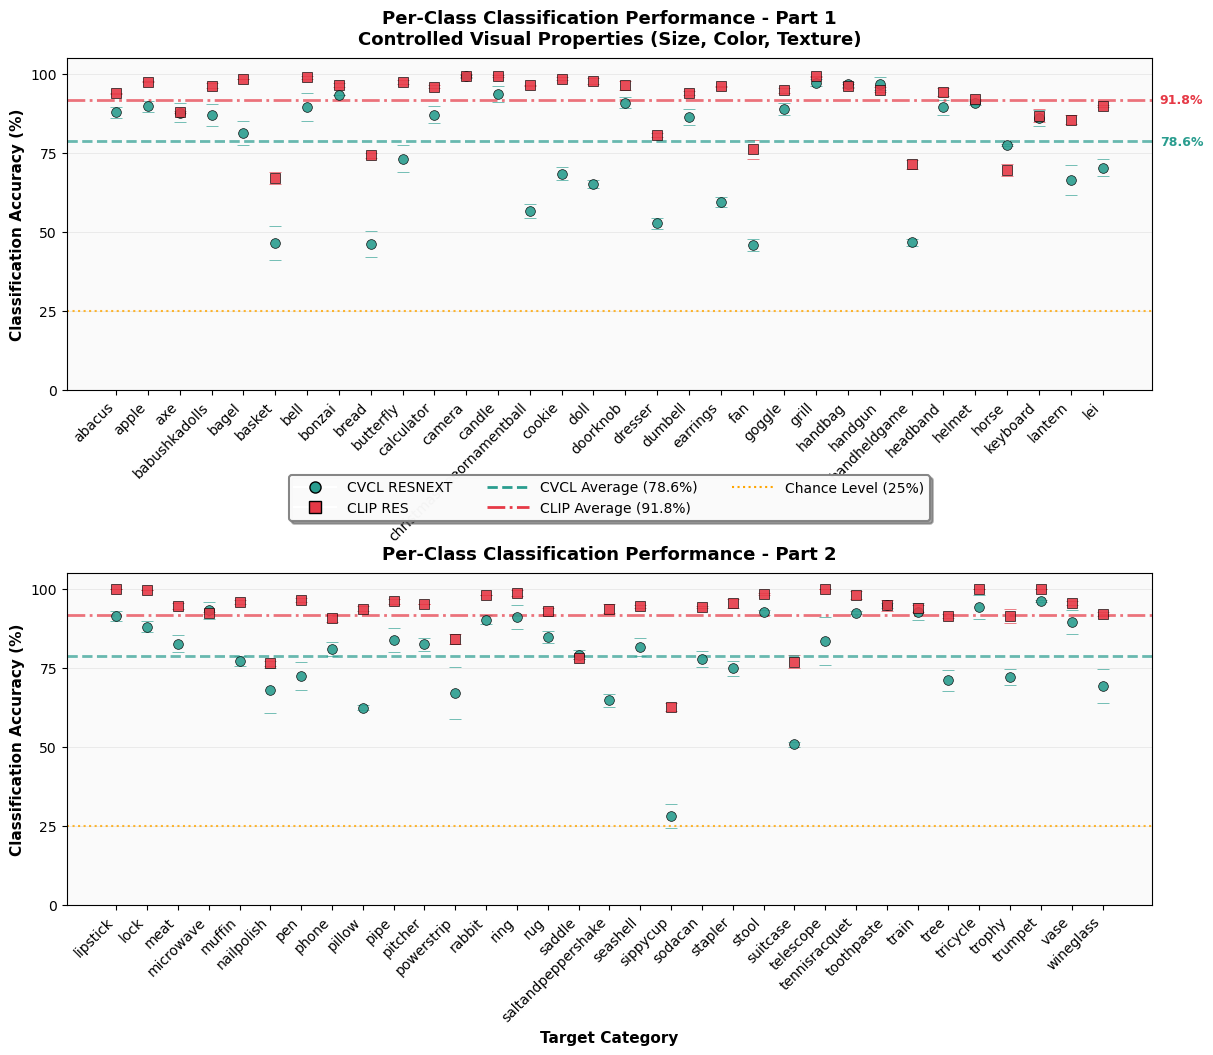

Saved split plots to:
  - c:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\class_perclass_split_publication.png
  - c:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\class_perclass_split_publication.pdf


In [35]:
# Create publication-quality visualization with two subplots for better readability
fig = plt.figure(figsize=(14, 11))

# Create subplots with space for legend in between
ax1 = plt.subplot2grid((20, 1), (0, 0), rowspan=8)
ax2 = plt.subplot2grid((20, 1), (12, 0), rowspan=8)

# Prepare data for plotting
classes = sorted(list(stats_results[models_to_test[0]].keys()))

# Split classes into two groups
mid_point = len(classes) // 2
classes_first_half = classes[:mid_point]
classes_second_half = classes[mid_point:]

# Define colors and styles to match the reference
colors = {
    'cvcl-resnext': '#2a9d8f',  # Teal/green color for CVCL
    'clip-res': '#e63946'  # Red color for CLIP - more distinct from CVCL
}
markers = {
    'cvcl-resnext': 'o',
    'clip-res': 's'  # Square for CLIP
}

# Different line styles for average lines
avg_line_styles = {
    'cvcl-resnext': '--',  # Dashed for CVCL
    'clip-res': '-.'  # Dash-dot for CLIP
}

# Store legend elements globally
legend_elements = []

# Function to plot data on an axis
def plot_on_axis(ax, class_subset, is_first=False):
    x_pos = np.arange(len(class_subset))
    
    # Plot each model as a line with error bars
    for model_name in models_to_test:
        means = [stats_results[model_name][cls]['mean'] * 100 for cls in class_subset]
        errors = [stats_results[model_name][cls]['ci95'] * 100 for cls in class_subset]
        
        # Plot line with markers and error bars
        ax.errorbar(x_pos, means, yerr=errors, 
                    label=model_name.upper().replace('-', ' '),
                    color=colors[model_name],
                    marker=markers[model_name],
                    markersize=7,
                    linewidth=0,  # No line connecting points
                    capsize=4,
                    capthick=1.5,
                    alpha=0.9,
                    markeredgecolor='black',
                    markeredgewidth=0.5)
    
    # Add horizontal dashed lines for reference levels
    ax.axhline(y=25, color='#ffa500', linestyle=':', alpha=0.8, linewidth=1.5)
    
    # Calculate overall averages (across ALL classes, not just subset)
    all_classes_means = {}
    for model_name in models_to_test:
        all_means = [stats_results[model_name][cls]['mean'] * 100 for cls in classes]
        all_classes_means[model_name] = np.mean(all_means)
    
    # Add horizontal lines for each model's OVERALL average with distinct styles
    for model_name in models_to_test:
        avg_performance = all_classes_means[model_name]
        ax.axhline(y=avg_performance, 
                  color=colors[model_name], 
                  linestyle=avg_line_styles[model_name], 
                  alpha=0.7, 
                  linewidth=2)  # Thicker line for visibility
        
        # Add label for the average line on the right side
        if is_first:  # Only label on first subplot
            model_label = model_name.upper().split('-')[0]
            ax.text(len(class_subset) + 0.8, avg_performance, 
                   f'{avg_performance:.1f}%', 
                   fontsize=9, 
                   color=colors[model_name], 
                   va='center',
                   fontweight='bold')
    
    # Formatting
    ax.set_ylabel('Classification Accuracy (%)', fontsize=11, fontweight='bold')
    
    # Set x-axis labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(class_subset, rotation=45, ha='right', fontsize=10)
    
    # Set y-axis limits and ticks
    ax.set_ylim(0, 105)
    ax.set_yticks([0, 25, 50, 75, 100])
    
    # Grid
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add background shading for readability
    ax.set_facecolor('#fafafa')
    
    # Create legend elements (only once)
    global legend_elements
    if is_first:
        from matplotlib.lines import Line2D
        legend_elements = []
        
        # Add marker for data points
        for model_name in models_to_test:
            legend_elements.append(
                Line2D([0], [0], marker=markers[model_name], color='w', 
                      markerfacecolor=colors[model_name], markeredgecolor='black',
                      markersize=8, label=model_name.upper().replace('-', ' '))
            )
        
        # Add average lines to legend
        for model_name in models_to_test:
            avg_val = all_classes_means[model_name]
            legend_elements.append(
                Line2D([0], [0], color=colors[model_name], 
                      linestyle=avg_line_styles[model_name], linewidth=2,
                      label=f'{model_name.upper().split("-")[0]} Average ({avg_val:.1f}%)')
            )
        
        # Add chance line
        legend_elements.append(
            Line2D([0], [0], color='#ffa500', linestyle=':', linewidth=1.5,
                  label='Chance Level (25%)')
        )

# Plot first half
plot_on_axis(ax1, classes_first_half, is_first=True)
ax1.set_title('Per-Class Classification Performance - Part 1\nControlled Visual Properties (Size, Color, Texture)', 
              fontsize=13, fontweight='bold', pad=10)

# Plot second half
plot_on_axis(ax2, classes_second_half, is_first=False)
ax2.set_title('Per-Class Classification Performance - Part 2', 
              fontsize=13, fontweight='bold', pad=10)
ax2.set_xlabel('Target Category', fontsize=11, fontweight='bold')

# Add legend in the middle space between plots
legend_ax = fig.add_axes([0.125, 0.44, 0.775, 0.08])  # [left, bottom, width, height]
legend_ax.axis('off')  # Hide the axis

# Create the legend in the middle
legend = legend_ax.legend(handles=legend_elements, 
                          loc='center', 
                          ncol=3,  # 3 columns for horizontal layout
                          fontsize=10,
                          frameon=True,
                          fancybox=True,
                          shadow=True,
                          framealpha=0.95,
                          columnspacing=2.5,
                          handlelength=3)

# Style the legend box
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)  # Adjust space between subplots

plt.savefig(os.path.join(RESULTS_DIR, 'class_perclass_split_publication.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(RESULTS_DIR, 'class_perclass_split_publication.pdf'), bbox_inches='tight', facecolor='white')
plt.show()

print(f"Saved split plots to:")
print(f"  - {os.path.join(RESULTS_DIR, 'class_perclass_split_publication.png')}")
print(f"  - {os.path.join(RESULTS_DIR, 'class_perclass_split_publication.pdf')}")

In [34]:
# Statistical summary table with publication formatting
summary_data = []
for cls in classes:
    row = {'Class': cls}
    for model in models_to_test:
        stats = stats_results[model][cls]
        row[f"{model}_mean"] = f"{stats['mean']:.3f}"
        row[f"{model}_ci95"] = f"±{stats['ci95']:.3f}"
        row[f"{model}_se"] = f"{stats['se']:.3f}"
    # Add difference
    diff = stats_results['clip-res'][cls]['mean'] - stats_results['cvcl-resnext'][cls]['mean']
    row['difference'] = f"{diff:+.3f}"
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n=== Per-Class Performance Summary (Publication Ready) ===")
print(summary_df.to_string(index=False))

# Save to LaTeX for paper
latex_table = summary_df.to_latex(index=False, float_format="%.3f", escape=False)
with open(os.path.join(RESULTS_DIR, 'class_performance_table.tex'), 'w') as f:
    f.write(latex_table)
print(f"\nSaved LaTeX table to {os.path.join(RESULTS_DIR, 'class_performance_table.tex')}")

# Overall statistics with confidence intervals
print("\n=== Overall Performance (Publication Ready) ===")
for model in models_to_test:
    all_accs = []
    for cls in classes:
        all_accs.extend(stats_results[model][cls]['raw'])
    mean = np.mean(all_accs)
    std = np.std(all_accs)
    se = std / np.sqrt(len(all_accs))
    ci95 = 1.96 * se
    print(f"{model}: {mean:.3f} ± {ci95:.3f} (SE: {se:.3f}, n={len(all_accs)} samples)")

# Statistical test between models
from scipy import stats as scipy_stats
cvcl_all = []
clip_all = []
for cls in classes:
    cvcl_all.extend(stats_results['cvcl-resnext'][cls]['raw'])
    clip_all.extend(stats_results['clip-res'][cls]['raw'])

t_stat, p_value = scipy_stats.ttest_ind(cvcl_all, clip_all)
print(f"\nPaired t-test: t={t_stat:.3f}, p={p_value:.6f}")
if p_value < 0.001:
    print("Result: Highly significant difference (p < 0.001)")
elif p_value < 0.01:
    print("Result: Significant difference (p < 0.01)")
elif p_value < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference")


=== Per-Class Performance Summary (Publication Ready) ===
                    Class cvcl-resnext_mean cvcl-resnext_ci95 cvcl-resnext_se clip-res_mean clip-res_ci95 clip-res_se difference
                   abacus             0.877            ±0.017           0.009         0.937        ±0.003       0.001     +0.060
                    apple             0.897            ±0.018           0.009         0.975        ±0.001       0.001     +0.078
                      axe             0.877            ±0.031           0.016         0.879        ±0.003       0.002     +0.002
            babushkadolls             0.870            ±0.035           0.018         0.962        ±0.008       0.004     +0.092
                    bagel             0.811            ±0.038           0.019         0.983        ±0.001       0.001     +0.172
                   basket             0.465            ±0.054           0.027         0.671        ±0.019       0.010     +0.206
                     bell             

In [ ]:
# Create difference plot (CLIP - CVCL)
plt.figure(figsize=(12, 6))

differences = []
for cls in classes:
    diff = stats_results['clip-res'][cls]['mean'] - stats_results['cvcl-resnext'][cls]['mean']
    differences.append(diff)

colors_diff = ['green' if d > 0 else 'red' for d in differences]
plt.bar(classes, differences, color=colors_diff, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Object Class', fontsize=12, fontweight='bold')
plt.ylabel('Performance Difference\n(CLIP - CVCL)', fontsize=12, fontweight='bold')
plt.title('Model Performance Differences by Class', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (cls, diff) in enumerate(zip(classes, differences)):
    plt.text(i, diff + (0.01 if diff > 0 else -0.02), f'{diff:.2f}', 
            ha='center', va='bottom' if diff > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'class_performance_difference.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved difference plot to {os.path.join(RESULTS_DIR, 'class_performance_difference.png')}")